In [1]:
from IPython.display import HTML
HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

# Prediction Models by Comorbidities
In this notebook we build different models to predict the 30-day readmission rate by the 29 comorbidity categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os

In [2]:
%matplotlib inline

In [ ]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [3]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [4]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

## Data reading and splitting
We first read the ami index cohort, select only the first admission of each patient, and do a train-test splitting. 

In [5]:
admissions = pd.read_csv(path+'cohorts/ami/comorbidities.csv')

In [8]:
admissions.columns

Index(['CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS',
       'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX',
       'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES',
       'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH',
       'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE',
       'CM_WGHTLOSS', 'KEY_NRD', 'AGE', 'FEMALE', 'HOSP_NRD', 'NRD_VisitLink',
       'NRD_DaysToEvent', 'readm30'],
      dtype='object')

In [6]:
comorb = [n for n in admissions.columns if n.startswith('CM')]

In [7]:
admissions = admissions.sort_values(['NRD_VisitLink', 'NRD_DaysToEvent'])

Pick only the first admission of each patient, i.e., one patient only contribute one sample:

In [8]:
patients_first = admissions.drop_duplicates(subset=['NRD_VisitLink'])

In [9]:
patients_first['readm30'].value_counts()

False    158104
True      23753
Name: readm30, dtype: int64

In [10]:
patients_first.to_csv(path+'cohorts/ami/patients_first.csv', index=False)

In [11]:
train_df, test_df = train_test_split(patients_first, test_size=0.25, random_state=123, stratify = patients_first['HOSP_NRD'])

In [12]:
train_df.to_csv(path+'cohorts/ami/comorb_train.csv', index=False)
test_df.to_csv(path+'cohorts/ami/comorb_test.csv', index=False)

In [6]:
train_df = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
test_df = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

## Mixed Effects Logistic Regression
This part is done by the R package lme4, in a separate notebook "Mixed_effect_logistic.ipynb". Here we directly read the result: prediction scores and the true outcomes for the test set.

In [32]:
pred_test = pd.read_csv(path+'cohorts/ami/prediction_MELR.csv')

### Result visualization

In [29]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import utils

In [30]:
from utils import plot_roc

In [33]:
from importlib import reload
reload(utils)
from utils import plot_roc

{0: 0.6645320712674248}

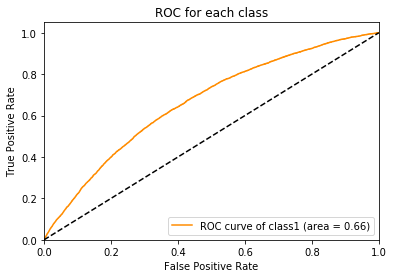

In [33]:
plot_roc(pred_test['y_pred'].values, pred_test['y_true'].values)

## Fully Connected Neural Nets

### Prepare the training data

In [13]:
N_train = len(train_df)
N_test = len(test_df)

In [14]:
X_train = train_df[['AGE', 'FEMALE']+comorb].values
X_test = test_df[['AGE', 'FEMALE']+comorb].values

mean_age = train_df['AGE'].mean()
sigma_age = train_df['AGE'].std()
X_train[:, 0] = (X_train[:, 0] - mean_age)/sigma_age
X_test[:, 0] = (X_test[:, 0] - mean_age)/sigma_age

In [15]:
mean_age, sigma_age

(66.18001788961229, 13.801148871105399)

In [16]:
hosp_series = pd.concat([train_df, test_df])['HOSP_NRD']
hosp_series = hosp_series.astype(int).astype('category')

old_cat = hosp_series.cat.categories
n_cat = len(old_cat)

hosp_series = hosp_series.cat.rename_categories(range(n_cat))
hosp_array = hosp_series.astype(int).values

hosp_train = hosp_array[:N_train]
hosp_test = hosp_array[N_train:]

In [17]:
y_train = train_df['readm30'].values.astype(int)
y_test = test_df['readm30'].values.astype(int)

In [62]:
X_train.shape, hosp_train.shape, y_train.shape, X_test.shape, hosp_test.shape, y_test.shape

((146771, 31), (146771,), (146771,), (48924, 31), (48924,), (48924,))

In [63]:
X_train.dtype, hosp_train.dtype, y_train.dtype

(dtype('float64'), dtype('int64'), dtype('float64'))

### Model building

In [18]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [20]:
input_X = Input(shape=(31,))

embed_dim = 1
input_hosp = Input(shape=(1,))
embed_out = Embedding(n_cat, embed_dim, input_length=1)(input_hosp)
embed_out = Reshape((embed_dim,))(embed_out)

merged_X = concatenate([input_X, embed_out], axis=1)

x = Dense(64, activation='relu')(merged_X)
x = Dense(64, activation='relu')(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
#x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_X, input_hosp], outputs=prediction)

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
checkpointer = ModelCheckpoint(filepath=model_path+'ami_comorb1.h5', verbose=0, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [23]:
class_weight = {0:(len(y_train)/sum(Y_train[:,0])), 1:(len(y_train)/sum(Y_train[:,1]))}

In [24]:
hist = model.fit([X_train, hosp_train], Y_train, batch_size=256, epochs=50, callbacks=[checkpointer, reduce_lr, earlystop],
                 validation_data=[[X_test, hosp_test], Y_test], class_weight = class_weight, verbose=2)

Train on 136392 samples, validate on 45465 samples
Epoch 1/50
 - 9s - loss: 1.3134 - acc: 0.5820 - val_loss: 0.6557 - val_acc: 0.5865
Epoch 2/50
 - 5s - loss: 1.2985 - acc: 0.5955 - val_loss: 0.6701 - val_acc: 0.5823
Epoch 3/50
 - 5s - loss: 1.2880 - acc: 0.5984 - val_loss: 0.6559 - val_acc: 0.5843
Epoch 4/50
 - 5s - loss: 1.2800 - acc: 0.6011 - val_loss: 0.6369 - val_acc: 0.5922
Epoch 5/50
 - 5s - loss: 1.2757 - acc: 0.5992 - val_loss: 0.6578 - val_acc: 0.5908
Epoch 6/50
 - 5s - loss: 1.2720 - acc: 0.5996 - val_loss: 0.6405 - val_acc: 0.5960
Epoch 7/50
 - 5s - loss: 1.2693 - acc: 0.6028 - val_loss: 0.6567 - val_acc: 0.5981
Epoch 8/50
 - 5s - loss: 1.2670 - acc: 0.6074 - val_loss: 0.6851 - val_acc: 0.5597
Epoch 9/50
 - 5s - loss: 1.2652 - acc: 0.6055 - val_loss: 0.6301 - val_acc: 0.6174
Epoch 10/50
 - 5s - loss: 1.2623 - acc: 0.6061 - val_loss: 0.6572 - val_acc: 0.5918
Epoch 11/50
 - 5s - loss: 1.2611 - acc: 0.6038 - val_loss: 0.6313 - val_acc: 0.6039
Epoch 12/50
 - 5s - loss: 1.2577 -

In [25]:
model.load_weights(model_path+'ami_comorb1.h5')

In [26]:
y_pred = model.predict([X_test, hosp_test], batch_size=128)

In [27]:
y_pred = y_pred[:,1]

{0: 0.6534134147567865}

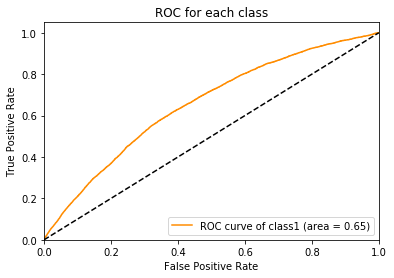

In [31]:
plot_roc(y_pred, y_test)